In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import mediapipe as mp
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from PIL import Image
import supervision as sv

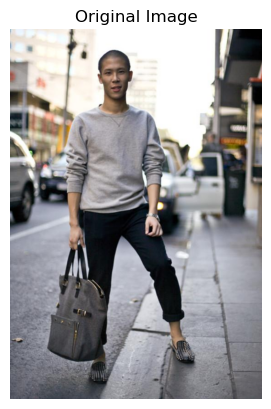

In [7]:
# Step 1: Load and display image

# 1.1 Set directories
DATA_DIR = "../../data/outfits/positive"
PERSON_DIR = "../../data/segmented_person"
ITEMS_DIR = "../../data/segmented_items"
folders = [DATA_DIR, PERSON_DIR, ITEMS_DIR]

# 1.2 Create the folders
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

# 1.3 Load image
image_files = [f for f in os.listdir(DATA_DIR) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
if not image_files:
    raise ValueError("No images found in the directory!")
image_path = os.path.join(DATA_DIR, image_files[100])
# image_path = os.path.join(DATA_DIR, "2024.jpg")
image_bgr = cv2.imread(image_path)
if image_bgr is None:
    raise ValueError(f"Failed to load image: {image_path}")

# 1.4 Convert for visualization
if image_bgr.shape[2] == 4:  # BGRA image (PNG with transparency)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGRA2RGBA)
elif image_bgr.shape[2] == 3:  # Standard BGR image
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
else:  # Grayscale or unexpected format
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_GRAY2RGB)

# 1.5 Display original image
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

In [9]:
from ultralytics import YOLO

# Load a pre-trained YOLOv8 model (e.g., the nano version)
model = YOLO("yolov8n.pt")  # You can use 'yolov8s.pt', 'yolov8m.pt', etc.
results = model(image_rgb)
results


0: 640x448 1 person, 2 cars, 1 handbag, 47.0ms
Speed: 2.4ms preprocess, 47.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [10]:
for result in results:
    boxes = result.boxes

bbox=boxes.xyxy.tolist()[0]

bbox

[116.1209716796875, 40.92675018310547, 396.9900817871094, 760.1127319335938]

In [12]:
# ---- load SAM ----
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "../../models/sam_vit_h.pth"

# URL to download the model (Hugging Face mirror for better accessibility)
url = "https://hf-mirror.com/HCMUE-Research/SAM-vit-h/resolve/main/sam_vit_h_4b8939.pth?download=true"  # [5]

# Create the directory if it does not exist
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

# Download if not present
if not os.path.exists(CHECKPOINT_PATH):
    print("Downloading sam_vit_h.pth...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(CHECKPOINT_PATH, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Download complete.")
else:
    print("sam_vit_h.pth already exists.")

# load SAM model with vit_h encoder (636M parameters)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to("cuda" if torch.cuda.is_available() else "cpu")

sam_vit_h.pth already exists.


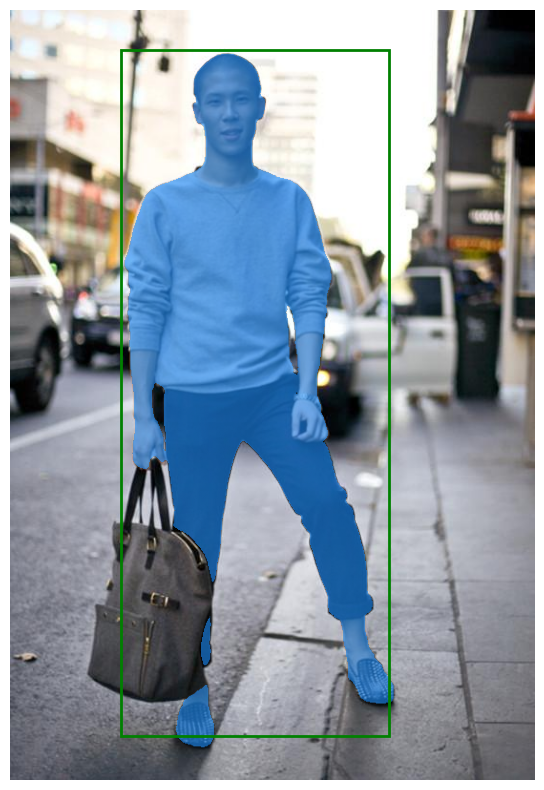

In [13]:
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

input_box = np.array(bbox)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

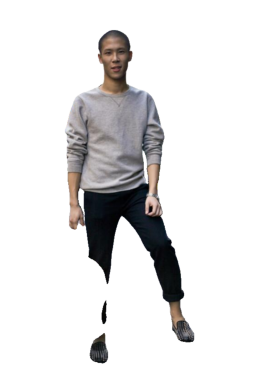

In [14]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

white_background = np.ones_like(image_rgb) * 255

new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image_rgb * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

I0000 00:00:1750352590.039977 16981149 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1750352590.135605 16984632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750352590.159633 16984632 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750352590.192877 16984629 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


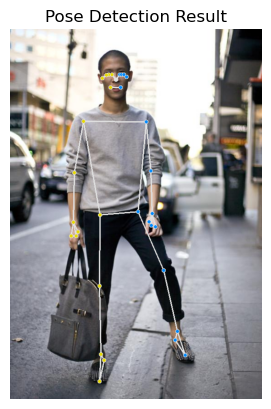

In [5]:
# ---- STEP 1: POSE ESTIMATION ----
# https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/pose_landmarker/python/%5BMediaPipe_Python_Tasks%5D_Pose_Landmarker.ipynb#scrollTo=tzXuqyIBlXer

base_options = python.BaseOptions(model_asset_path='../../models/pose_landmarker_full.task')
options = vision.PoseLandmarkerOptions(base_options=base_options, output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb)
detection_result = detector.detect(mp_image)
if not detection_result.pose_landmarks:
    raise ValueError("Pose estimation failed!")

# Draw pose landmarks
annotated_image = draw_landmarks_on_image(image_rgb, detection_result)
plt.imshow(annotated_image)
plt.title("Pose Detection Result")
plt.axis("off")
plt.show()

I0000 00:00:1750352621.849409 16981149 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1750352621.911052 16985412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750352621.923686 16985412 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


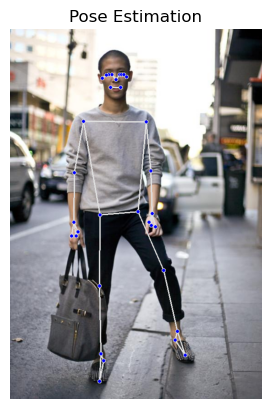

In [6]:
# --- Step 1: Pose Estimation with MediaPipe ---
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(image_rgb)

if not results.pose_landmarks:
    print("No pose detected.")
else:
    annotated_image = image_rgb.copy()
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing.draw_landmarks(annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
    
    plt.imshow(annotated_image)
    plt.title("Pose Estimation")
    plt.axis("off")
    plt.show()

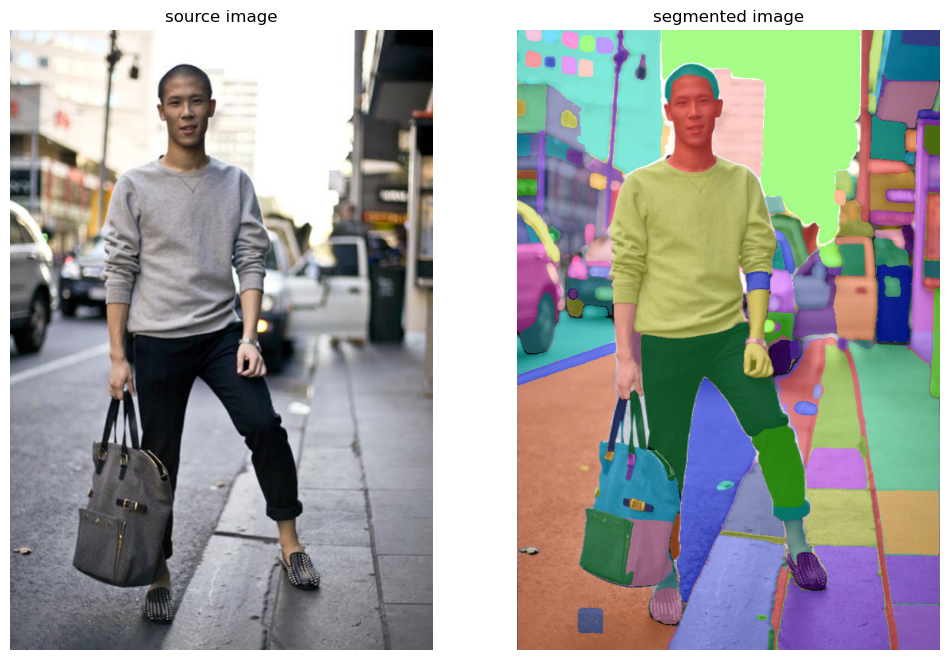

In [8]:
# ---- STEP 2: PERSON SEGMENTATION USING SAM ----
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "../../models/sam_vit_h.pth"

# URL to download the model (Hugging Face mirror for better accessibility)
url = "https://hf-mirror.com/HCMUE-Research/SAM-vit-h/resolve/main/sam_vit_h_4b8939.pth?download=true"  # [5]

# Create the directory if it does not exist
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

# Download if not present
if not os.path.exists(CHECKPOINT_PATH):
    print("Downloading sam_vit_h.pth...")
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(CHECKPOINT_PATH, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    print("Download complete.")
else:
    print("sam_vit_h.pth already exists.")

# load SAM model with vit_h encoder (636M parameters)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.56,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,
)
sam_result = mask_generator.generate(image_rgb)
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

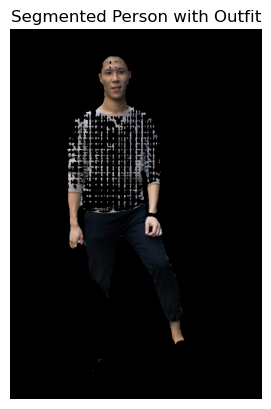

In [13]:
# ---- STEP 3: FILTER MASK FOR THE PERSON AND EXTRACT ----

def get_pose_keypoints(pose_landmarks):
    """Extract key points for filtering the person's mask."""
    keypoints = {}
    for idx, lm in enumerate(pose_landmarks):
        keypoints[idx] = (int(lm.x * image_rgb.shape[1]), int(lm.y * image_rgb.shape[0]))
    return keypoints

# Get pose keypoints
pose_keypoints = get_pose_keypoints(detection_result.pose_landmarks[0])

# Define a bounding box around the person using pose keypoints
x_min = min([kp[0] for kp in pose_keypoints.values()])
y_min = min([kp[1] for kp in pose_keypoints.values()])
x_max = max([kp[0] for kp in pose_keypoints.values()])
y_max = max([kp[1] for kp in pose_keypoints.values()])

person_bbox = np.array([[x_min, y_min, x_max, y_max]])

# Predict masks for the person using SAM
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)
masks, _, _ = predictor.predict(box=person_bbox, multimask_output=False)

# Convert mask to binary format
binary_mask = masks[0].astype(np.uint8) * 255

# Apply the mask to extract the person
person_segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

# Display the segmented person
plt.imshow(person_segmented)
plt.title("Segmented Person with Outfit")
plt.axis("off")
plt.show()

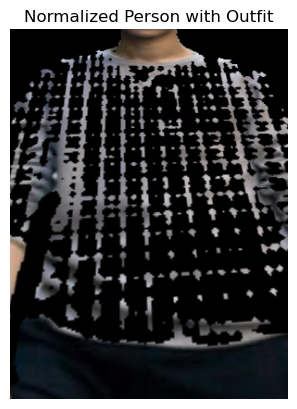

Normalized person saved at: ../data/segmented_person/normalized_person_2024.jpg


In [14]:
# ---- STEP 4: NORMALIZE THE IMAGE ----

# Perspective correction (optional but recommended for normalization)
if all(k in pose_keypoints for k in [11, 12, 23, 24]):  # Shoulders and hips
    src_pts = np.array([
        pose_keypoints[11],  # Left shoulder
        pose_keypoints[12],  # Right shoulder
        pose_keypoints[23],  # Left hip
        pose_keypoints[24]   # Right hip
    ], dtype=np.float32)

    dst_pts = np.array([
        [50, 50],            # Top-left
        [250, 50],           # Top-right
        [50, 350],           # Bottom-left
        [250, 350]           # Bottom-right
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    normalized_person = cv2.warpPerspective(person_segmented, M, (300, 400))

    # Display the normalized person
    plt.imshow(normalized_person)
    plt.title("Normalized Person with Outfit")
    plt.axis("off")
    plt.show()
else:
    print("Keypoints for perspective correction missing. Skipping normalization.")

# Resize the image to a standard size (e.g., 256x256)
normalized_person_resized = cv2.resize(normalized_person, (256, 256), interpolation=cv2.INTER_LINEAR)

# Save the normalized person image
normalized_person_path = os.path.join(PERSON_DIR, f"normalized_person_{os.path.basename(image_path)}")
cv2.imwrite(normalized_person_path, cv2.cvtColor(normalized_person_resized, cv2.COLOR_RGB2BGR))

print(f"Normalized person saved at: {normalized_person_path}")

In [ ]:
# WeirdOutfitStyle
from datasets import load_dataset
ds = load_dataset("Norod78/WeirdOutfitStyle")

In [ ]:
# Office Outfit Train Data
import kagglehub
path = kagglehub.dataset_download("jubeena/office-outfit-train-outfits")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("llkdev/fashionstyle")
print("Path to dataset files:", path)

In [ ]:
import kagglehub
path = kagglehub.dataset_download("khizerraza/men-vs-women-images-dataset")
print("Path to dataset files:", path)